In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy
import csv

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'bird', 'cat', 'deer'}
fg_used = '234'
fg1, fg2, fg3 = 2,3,4


all_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
background_classes = all_classes - foreground_classes
background_classes

# print(type(foreground_classes))

{'car', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck'}

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

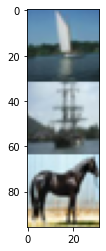

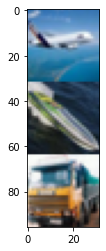

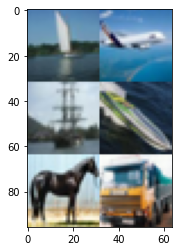

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)


0


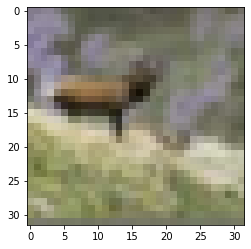

bird


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]]) 

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [0]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")
    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
      y = y.contiguous()


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.contiguous()
    y1 = y1.reshape(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y

In [0]:
fore_net = Module2().double()
fore_net = fore_net.to("cuda")

In [0]:
fore_net.load_state_dict(torch.load("/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch182_fg_used234_trial.pt"))

<All keys matched successfully>

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 600

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  cnt=0
  mini_loss = []

  iteration = desired_num // batch

  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels, fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")

    optimizer.zero_grad()
    
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)


    loss = criterion(outputs, labels) 
    loss.backward()

    optimizer.step()
    running_loss += loss.item()
    mini = 40
  
    if cnt % mini == mini - 1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      mini_loss.append(running_loss / mini)
      running_loss = 0.0
      
    cnt=cnt+1
  if(np.average(mini_loss) <= 0.05):
    break
print('Finished Training')
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 1.315
[1,    80] loss: 0.940
[1,   120] loss: 0.886
[2,    40] loss: 0.834
[2,    80] loss: 0.808
[2,   120] loss: 0.796
[3,    40] loss: 0.755
[3,    80] loss: 0.736
[3,   120] loss: 0.753
[4,    40] loss: 0.697
[4,    80] loss: 0.701
[4,   120] loss: 0.709
[5,    40] loss: 0.677
[5,    80] loss: 0.668
[5,   120] loss: 0.677
[6,    40] loss: 0.645
[6,    80] loss: 0.660
[6,   120] loss: 0.655
[7,    40] loss: 0.615
[7,    80] loss: 0.634
[7,   120] loss: 0.631
[8,    40] loss: 0.606
[8,    80] loss: 0.626
[8,   120] loss: 0.624
[9,    40] loss: 0.595
[9,    80] loss: 0.619
[9,   120] loss: 0.632
[10,    40] loss: 0.577
[10,    80] loss: 0.591
[10,   120] loss: 0.607
[11,    40] loss: 0.579
[11,    80] loss: 0.579
[11,   120] loss: 0.601
[12,    40] loss: 0.560
[12,    80] loss: 0.574
[12,   120] loss: 0.619
[13,    40] loss: 0.573
[13,    80] loss: 0.580
[13,   120] loss: 0.600
[14,    40] loss: 0.590
[14,    80] loss: 0.550
[14,   120] loss: 0.578
[15,    40] loss: 0

In [0]:
# torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch"+str(epoch)+"_fg_used"+str(fg_used)+".pt")

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
test_set_labels = []
for i in range(10000):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)
  test_set_labels.append(set_idx)


In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [19]:
torch.argmax(alphas[5]), alphas[5]

(tensor(6, device='cuda:0', grad_fn=<NotImplemented>),
 tensor([9.8109e-03, 1.2046e-02, 5.3874e-02, 2.4994e-02, 1.8140e-02, 3.2116e-02,
         8.4582e-01, 2.8830e-03, 3.1212e-04], device='cuda:0',
        dtype=torch.float64, grad_fn=<SelectBackward>))

In [0]:
test_set = DataLoader( test_data,batch_size= batch ,shuffle=False)
train_set = DataLoader( msd,batch_size= batch ,shuffle=False)

#TRAIN SUMMARY

In [21]:
fg = [fg1, fg2, fg3]
all_list = [0,1,2,3,4,5,6,7,8,9]
bg = list(set(all_list)-set(fg))
fg, bg

([2, 3, 4], [0, 1, 5, 6, 7, 8, 9])

In [22]:
from tabulate import tabulate
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)
print(count)

print("="*100)
table3 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),30000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

train_entry = entry

table3.append(entry)

print(tabulate(table3, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 30000 train images: 98 %
total correct 29627
total train set images 30000
focus_true_pred_true 20047 =============> FTPT : 66 %
focus_false_pred_true 9580 =============> FFPT : 31 %
focus_true_pred_false 48 =============> FTPF : 0 %
focus_false_pred_false 325 =============> FFPF : 1 %
argmax_more_than_half 23540
argmax_less_than_half 6460
30000
  S.No.  fg_class        bg_class                      data_points     FTPT     FFPT    FTPF     FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  -------  -------  ------  -------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000  66.8233  31.9333    0.16  1.08333            23540


#TEST SUMMARY

In [23]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

print("="*100)
table4 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),10000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

test_entry = entry 

table4.append(entry)

print(tabulate(table4, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 10000 test images: 70 %
total correct 7036
total train set images 10000
focus_true_pred_true 5637 =============> FTPT : 56 %
focus_false_pred_true 1399 =============> FFPT : 13 %
focus_true_pred_false 700 =============> FTPF : 7 %
focus_false_pred_false 2264 =============> FFPF : 22 %
argmax_more_than_half 7467
argmax_less_than_half 2533
  S.No.  fg_class        bg_class                      data_points    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  ------  ------  ------  ------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000   56.37   13.99       7   22.64             7467


#Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes separetly

In [24]:
from tabulate import tabulate
table1 = []
table1.append(train_entry)
entry_no = 2


# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in train_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 30000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table1.append(entry)
    entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(table1, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000    66.8233    31.9333   0.16       1.08333             23540
      2  fg = 2          bg = all_except_fg                   9928    70.4371    28.1225   0.191378   1.24899              8035
      3  fg = 3          bg = all_except_fg                  10040    55.7769    43.2968   0.119522   0.806773             7189
      4  fg = 4          bg = all_except_fg                  10032    74.3022    24.3321   0.169458   1.19617              8316


In [25]:
# for testing_set
table2 = []
table2.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in test_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 10000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table2.append(entry)
    entry_no += 1

print("="*20+"Testing DATA"+"="*20)
print(tabulate(table2, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Testing DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000    56.37      13.99      7          22.64               7467
      2  fg = 2          bg = all_except_fg                   3328    57.0312    13.9724    6.73077    22.2656             2510
      3  fg = 3          bg = all_except_fg                   3367    56.2519    13.5729    7.33591    22.8393             2532
      4  fg = 4          bg = all_except_fg                   3305    55.8245    14.4327    6.9289     22.8139             2425


#Set Size 1 
##3 in BG, 4 in BG, 5 in BG and so on
## On Training DATA


In [26]:
size1_table=[]
size1_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in train_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 30000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000    66.8233    31.9333  0.16        1.08333             23540
      2  fg = 2          bg = 0                               7027    70.5707    27.9493  0.227693    1.25231              5681
      3  fg = 2          bg = 1                               7025    70.4911    28.1139  0.185053    1.20996              5717
      4  fg = 2          bg = 5                               7016    69.9544    28.549   0.171038    1.32554              5682
      5  fg = 2          bg = 6                               7013    69.8132    28.6611  0.156852    1.36889              5632
      6  fg = 2          bg = 7                   

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size1_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [28]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size1_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  1.083333          23540
1      2          fg = 2  ...  1.252313           5681
2      3          fg = 2  ...  1.209964           5717
3      4          fg = 2  ...  1.325542           5682
4      5          fg = 2  ...  1.368886           5632

[5 rows x 9 columns]

In [29]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0 , id0)

l,u = 8,14
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1 , id1)

l,u = 15,21
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2 , id2)

66.82333333333334 31.93333333333333 0.16 1.0833333333333333
[70.57065604098476 70.49110320284697 69.95438996579246 69.81320404962213
 70.80928923293456 70.93789429412591] ['bg = 0' 'bg = 1' 'bg = 5' 'bg = 6' 'bg = 7' 'bg = 8']
[55.99380194393578 56.1354414439625 54.7496164039615 54.87957677850481
 55.666901905434024 56.55451626413514] ['bg = 0' 'bg = 1' 'bg = 5' 'bg = 6' 'bg = 7' 'bg = 8']
[74.56140350877193 74.53162417241865 73.5796249650154 73.58941888279162
 73.86941775014131 74.5772266065389] ['bg = 0' 'bg = 1' 'bg = 5' 'bg = 6' 'bg = 7' 'bg = 8']


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size1/train/"

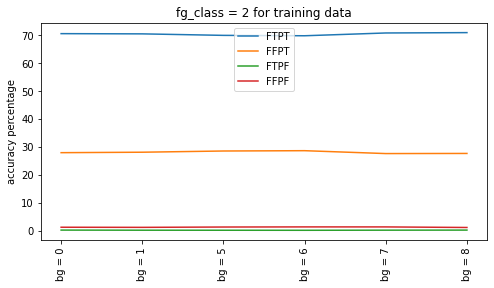

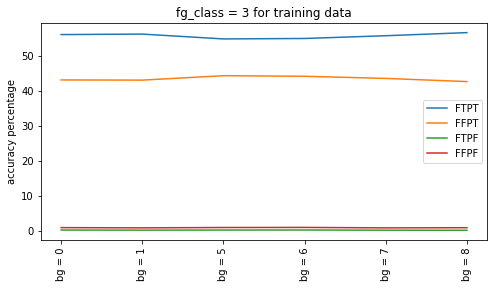

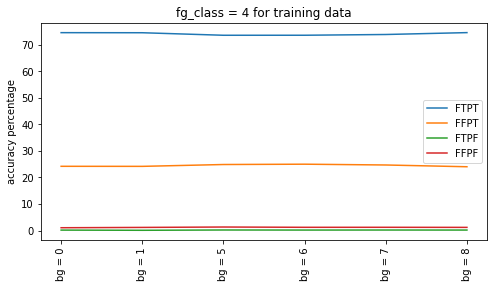

In [31]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

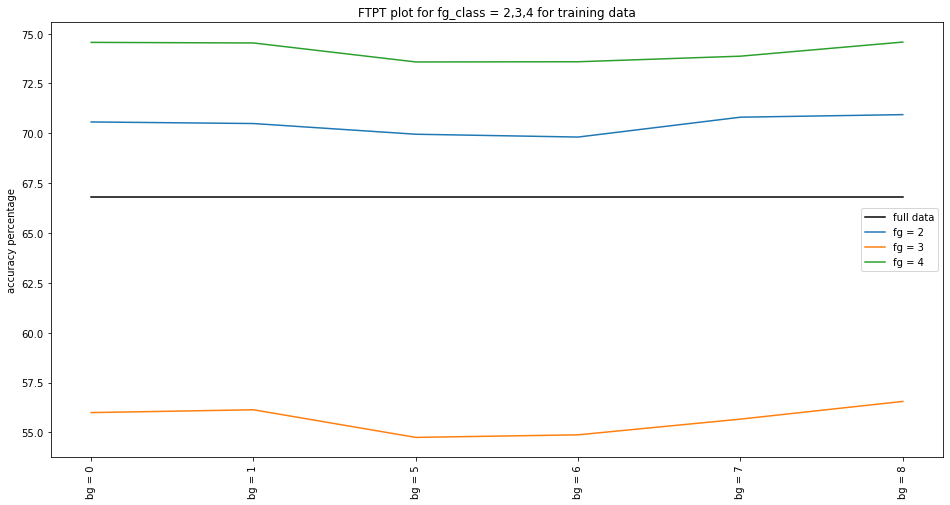

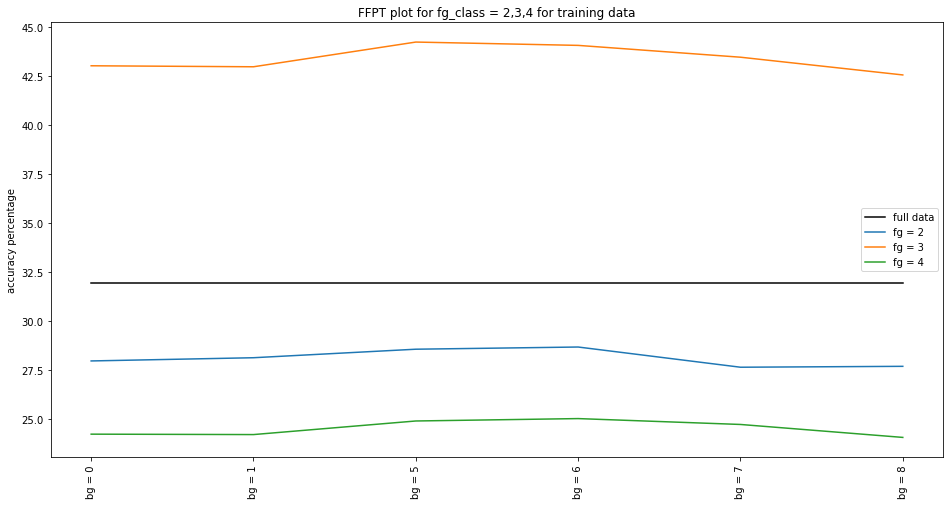

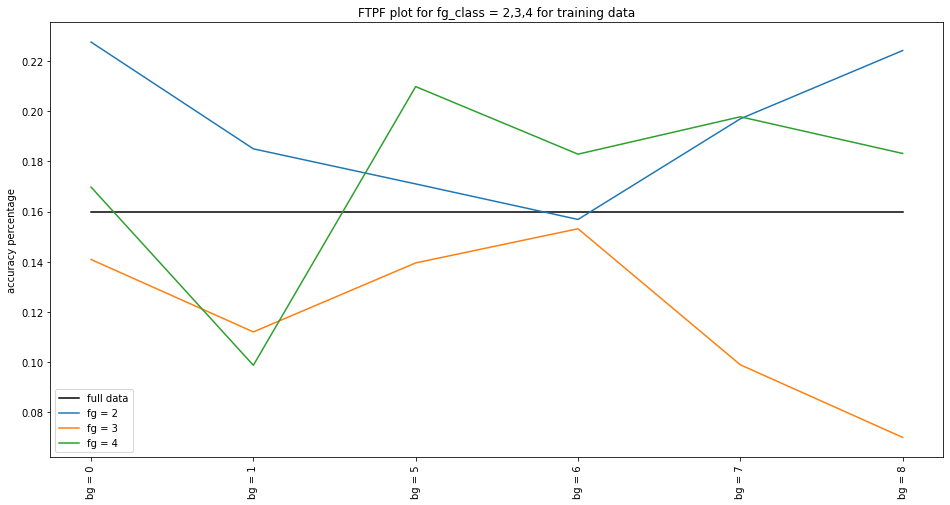

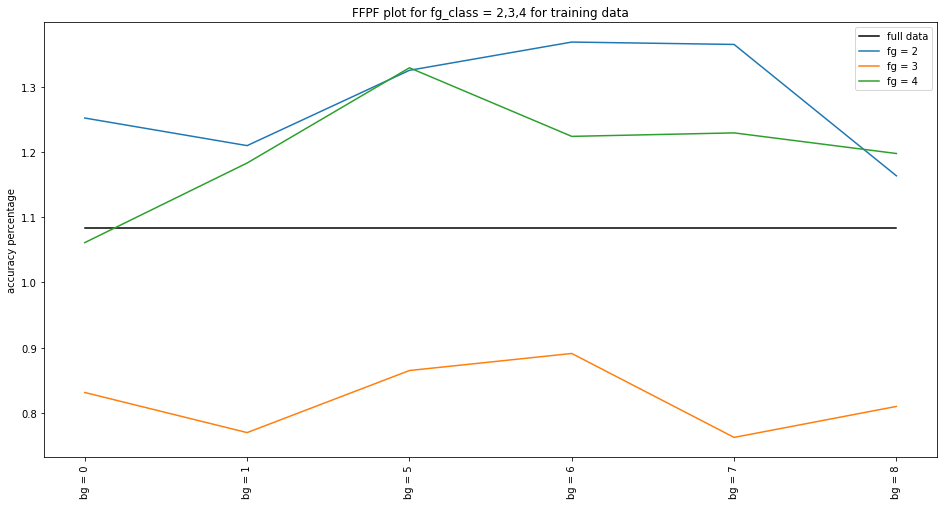

In [32]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [33]:
size1_table=[]
size1_table.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in test_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 10000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000    56.37      13.99      7          22.64               7467
      2  fg = 2          bg = 0                               2384    56.7534    14.1779    6.41779    22.651              1781
      3  fg = 2          bg = 1                               2368    56.4189    13.8514    7.13682    22.5929             1796
      4  fg = 2          bg = 5                               2362    56.3082    14.3099    6.64691    22.735              1763
      5  fg = 2          bg = 6                               2342    57.6003    13.9197    6.74637    21.7336             1773
      6  fg = 2          bg = 7                       

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size1_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [35]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size1_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  22.640000           7467
1      2          fg = 2  ...  22.651007           1781
2      3          fg = 2  ...  22.592905           1796
3      4          fg = 2  ...  22.734970           1763
4      5          fg = 2  ...  21.733561           1773

[5 rows x 9 columns]

In [36]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0)

l,u = 8,14
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1)

l,u = 15,21
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2)

56.37 13.99 7.0 22.64
[56.75335570469799 56.418918918918926 56.308213378492795 57.600341588386
 56.3613758806465 57.2977481234362]
[56.87103594080339 56.964656964656974 55.188284518828446
 55.643153526970956 56.62751677852349 55.82667227597813]
[55.694564279551344 56.57505285412263 56.44406635474266 55.08365508365508
 56.46404109589041 56.08397600685518]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size1/test/"

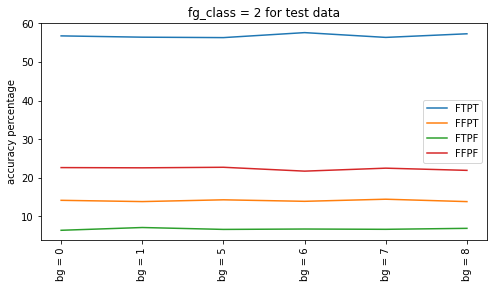

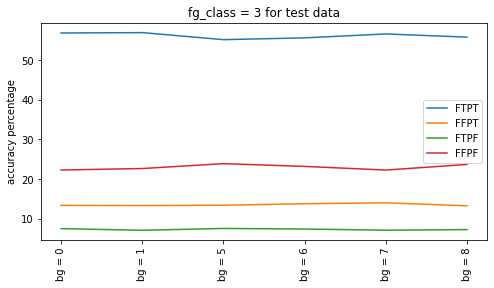

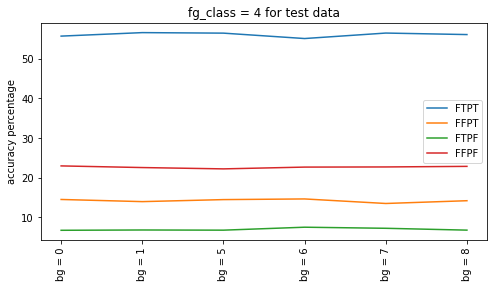

In [38]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

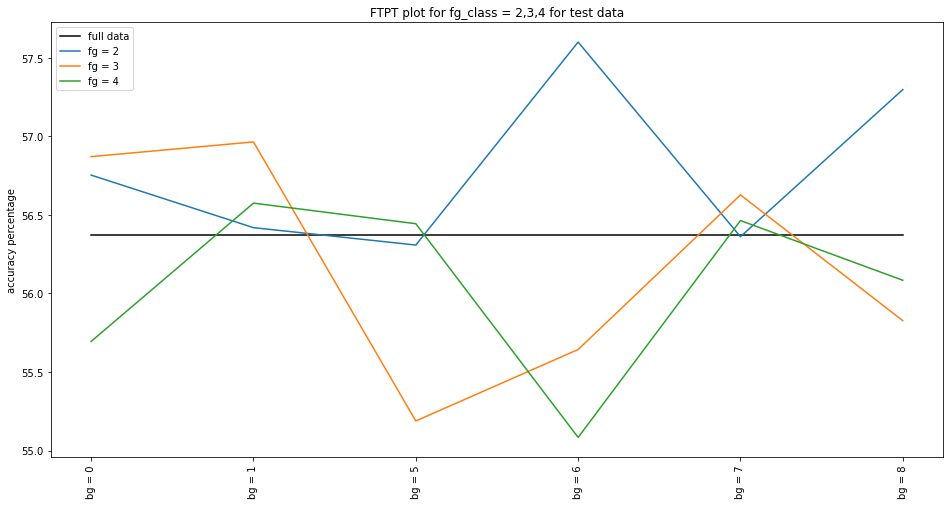

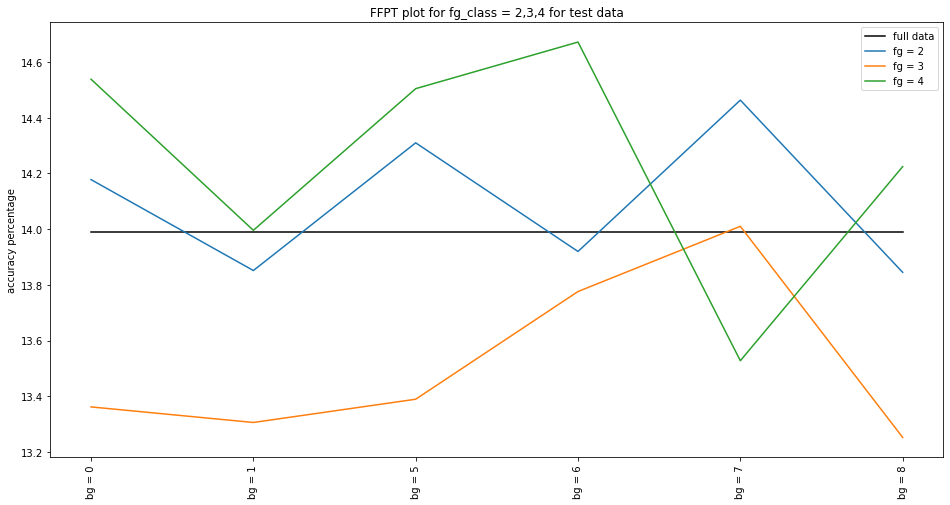

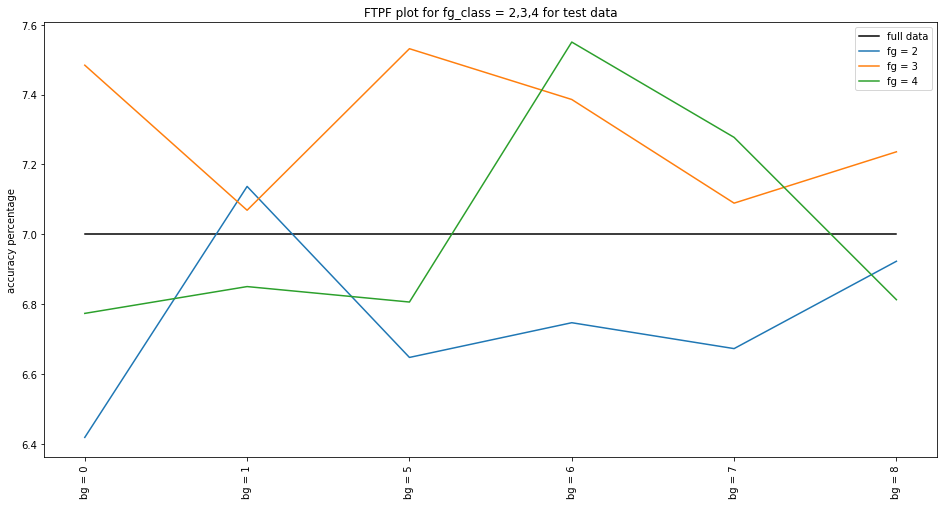

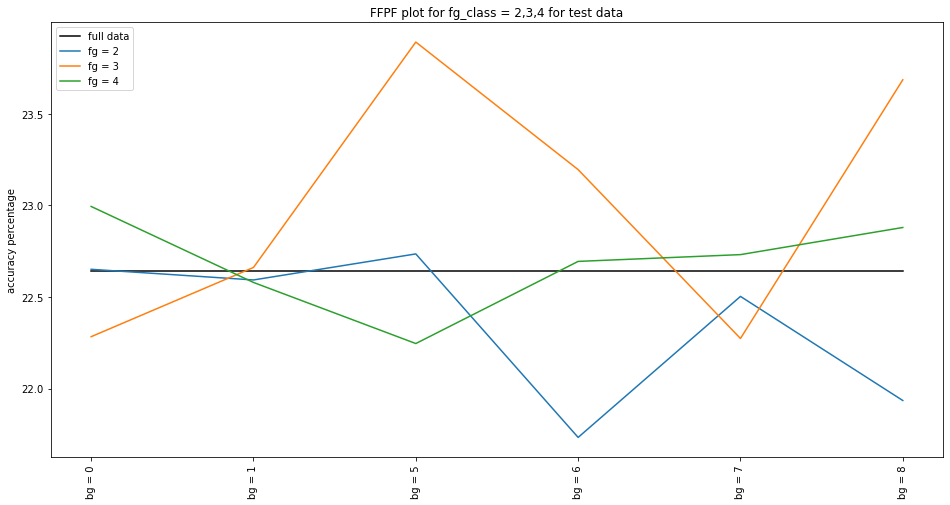

In [39]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 2 , Repetition allowed
## 33 in BG, 34 in BG, 35 in BG and so on
## On Training DATA


In [40]:
size2_table=[]
size2_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1, b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in train_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 30000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 in s and b2 in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1) + str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table.append(entry)
        entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size2_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000    66.8233    31.9333  0.16        1.08333             23540
      2  fg = 2          bg = 00                              7027    70.5707    27.9493  0.227693    1.25231              5681
      3  fg = 2          bg = 01                              4769    70.7276    27.7836  0.209688    1.27909              3879
      4  fg = 2          bg = 05                              4806    70.2247    28.2772  0.187266    1.31086              3893
      5  fg = 2          bg = 06                              4787    69.8559    28.5147  0.188009    1.4414               3834
      6  fg = 2          bg = 07                  

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size2_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table[i])

In [42]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size2_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  1.083333          23540
1      2          fg = 2  ...  1.252313           5681
2      3          fg = 2  ...  1.279094           3879
3      4          fg = 2  ...  1.310861           3893
4      5          fg = 2  ...  1.441404           3834

[5 rows x 9 columns]

In [43]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 50,98
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

66.82333333333334 31.93333333333333 0.16 1.0833333333333333
[70.57065604098476 70.72761585237996 70.2247191011236 69.85585961980364]
[55.99380194393578 56.025456785054395 54.878048780487795 54.80710349050827]
[74.56140350877193 74.84942886812046 73.67010309278349 74.01981015270327]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size2/train/"

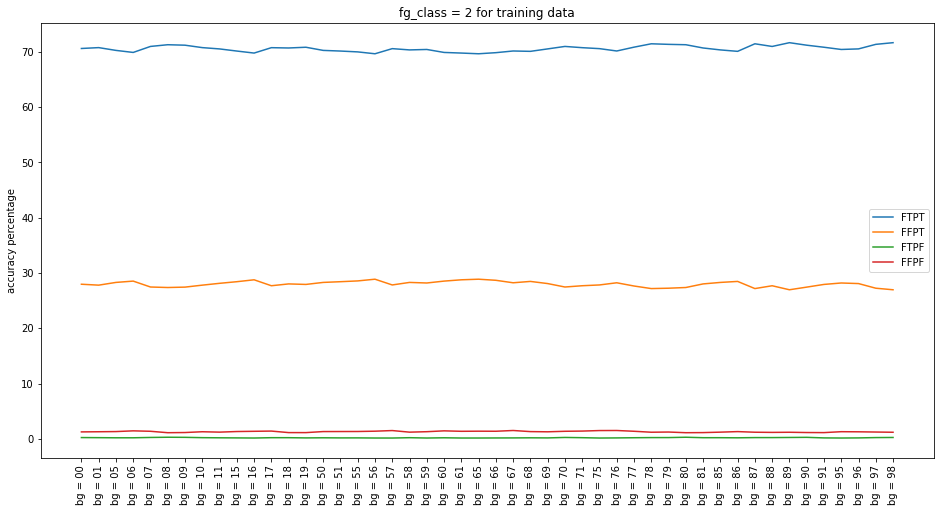

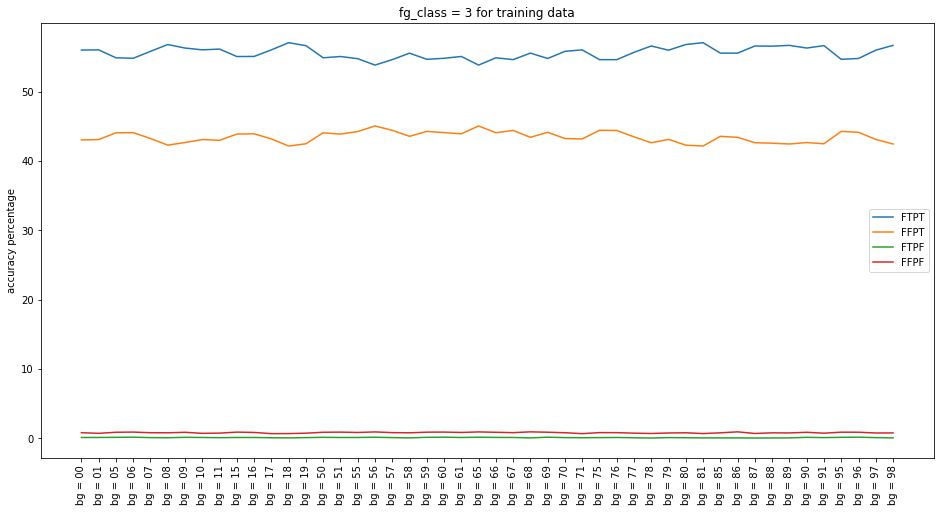

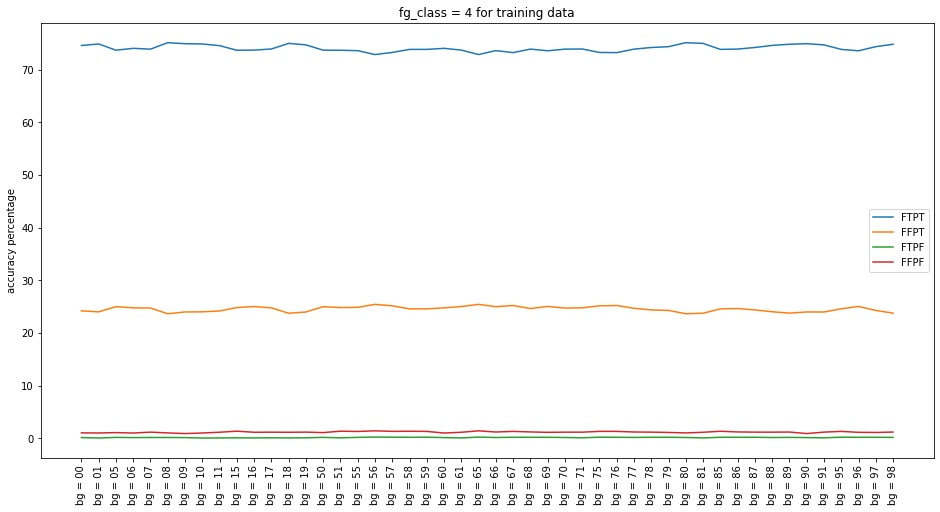

In [45]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

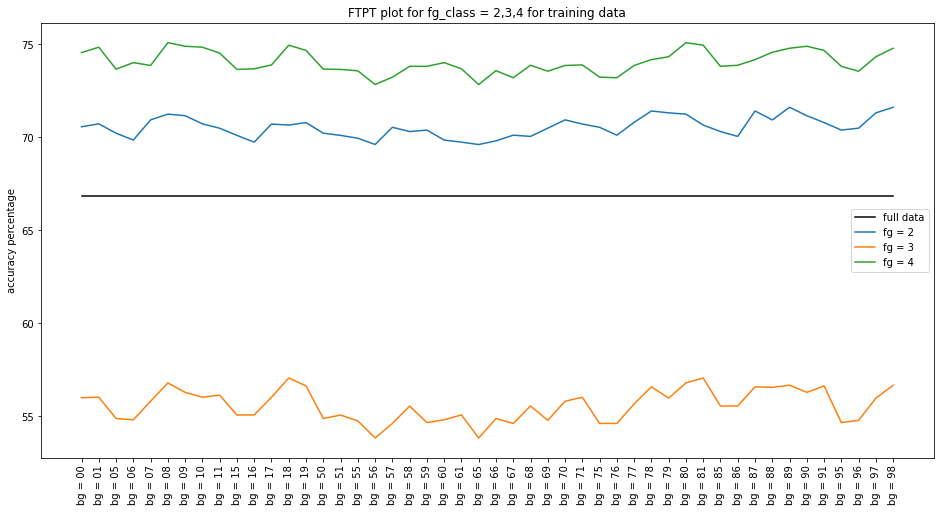

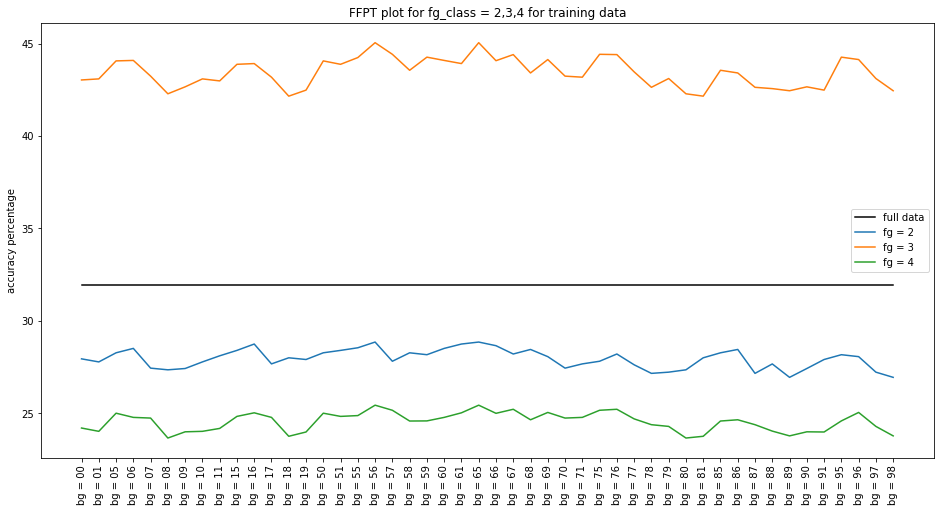

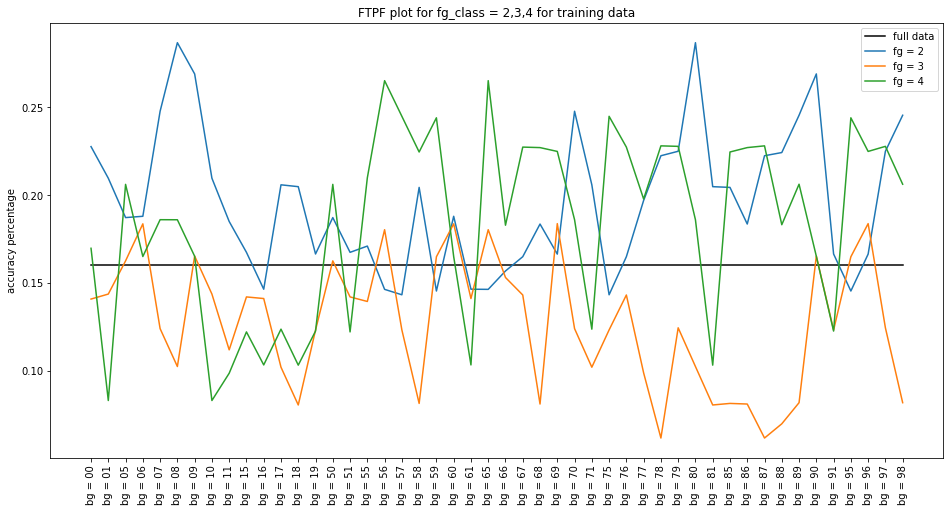

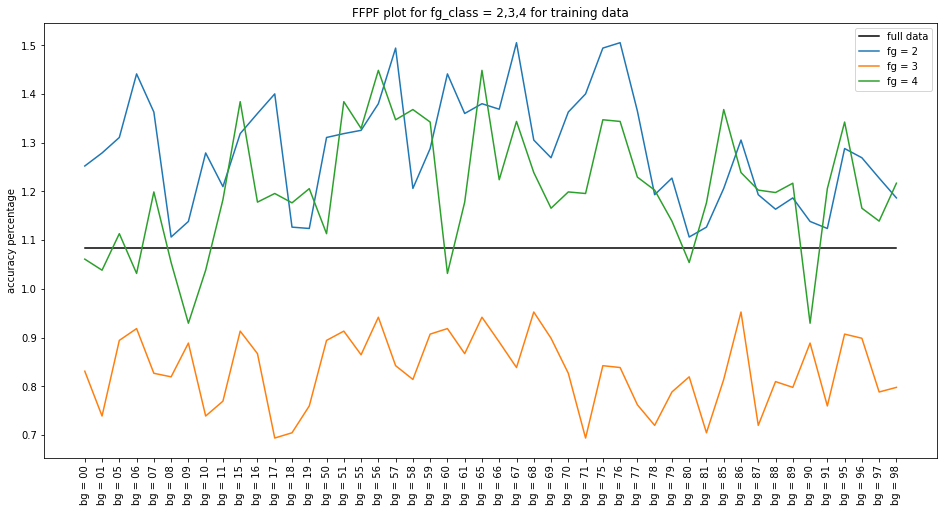

In [46]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [47]:
size2_table_test=[]
size2_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1,b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in test_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 10000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 in s and b2 in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table_test.append(entry)
        entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size2_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000    56.37      13.99      7          22.64               7467
      2  fg = 2          bg = 00                              2384    56.7534    14.1779    6.41779    22.651              1781
      3  fg = 2          bg = 01                              1634    56.6707    14.1371    6.79315    22.399              1233
      4  fg = 2          bg = 05                              1644    55.4136    14.5985    6.26521    23.7226             1211
      5  fg = 2          bg = 06                              1628    57.3096    14.312     6.51106    21.8673             1225
      6  fg = 2          bg = 07                      

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size2_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table_test[i])

In [49]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size2_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  22.640000           7467
1      2          fg = 2  ...  22.651007           1781
2      3          fg = 2  ...  22.399021           1233
3      4          fg = 2  ...  23.722628           1211
4      5          fg = 2  ...  21.867322           1225

[5 rows x 9 columns]

In [50]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 50,98
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

56.37 13.99 7.0 22.64
[56.75335570469799 56.670746634026926 55.413625304136254 57.30958230958231]
[56.87103594080339 57.57575757575758 55.2760736196319 55.88235294117647]
[55.694564279551344 56.03773584905661 56.35324015247777 55.139593908629436]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size2/test/"

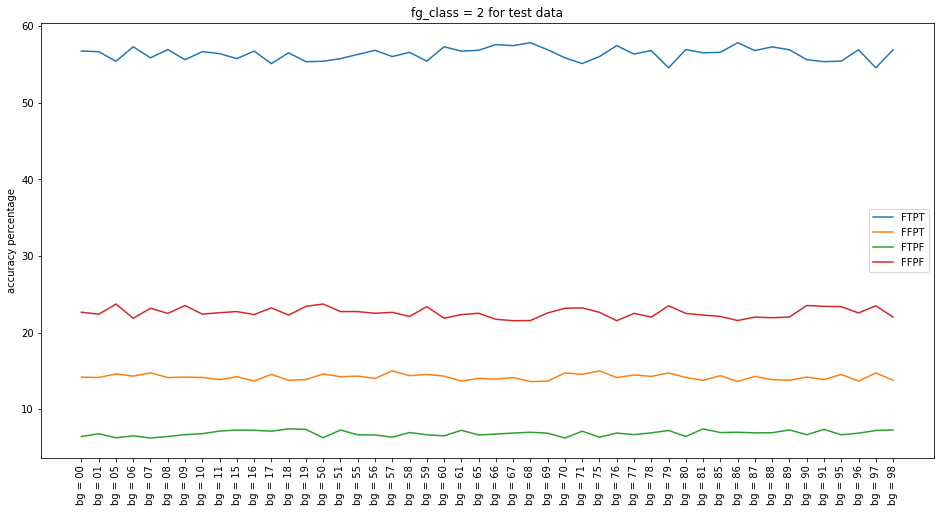

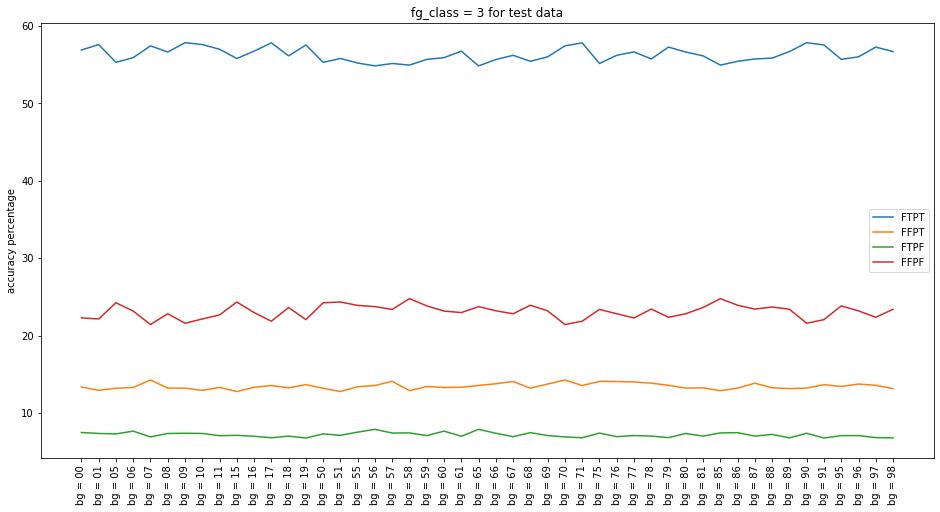

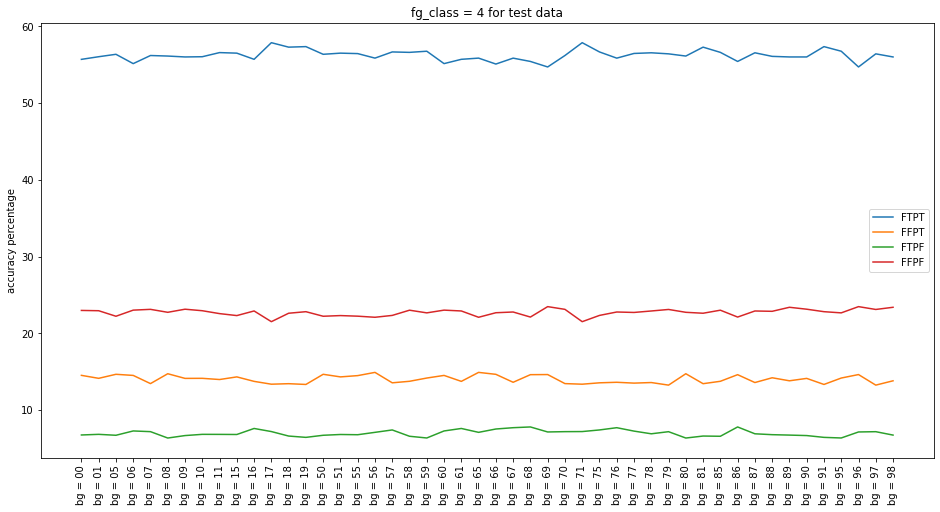

In [52]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

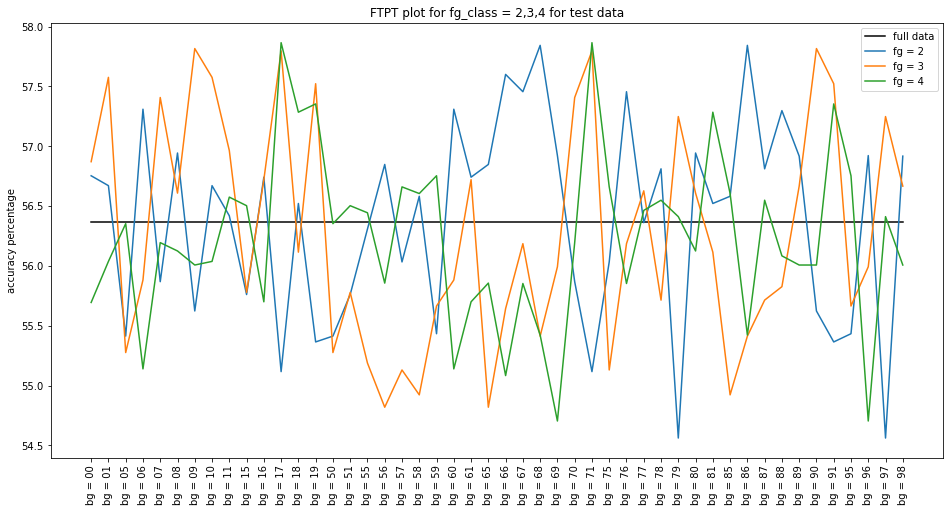

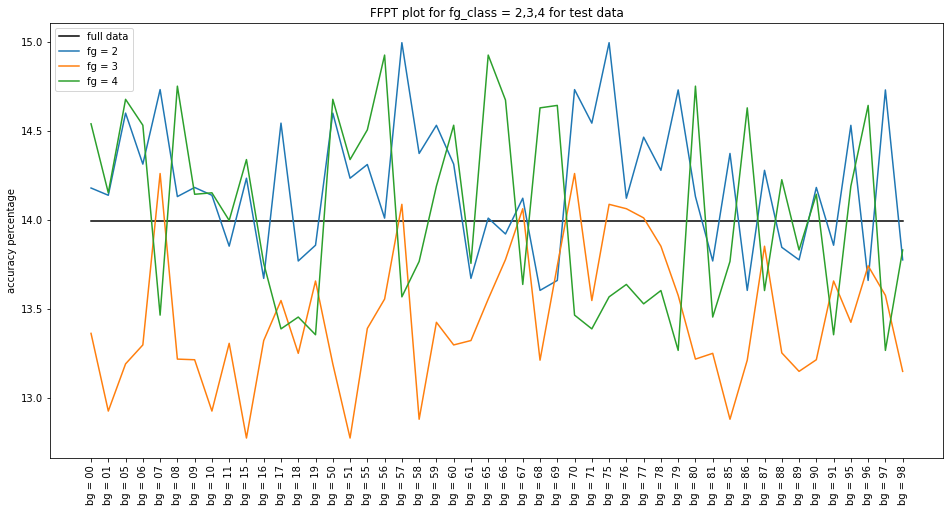

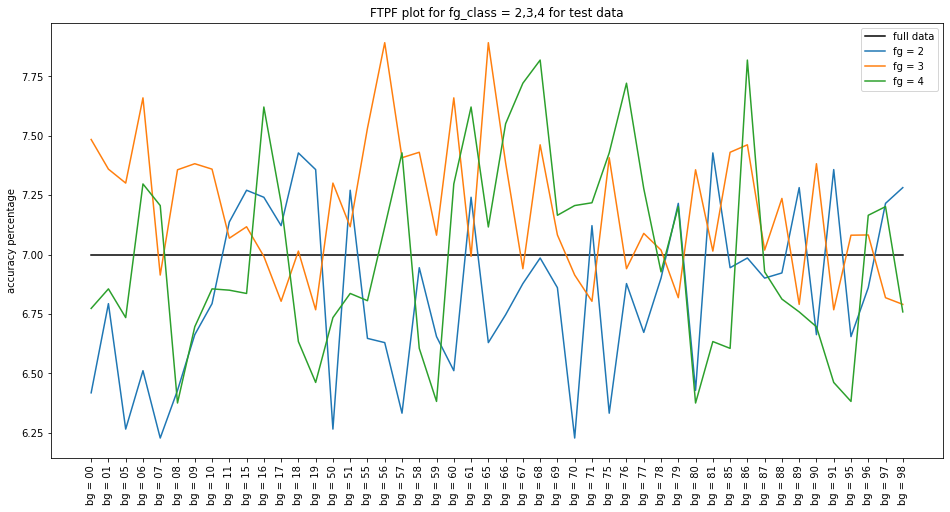

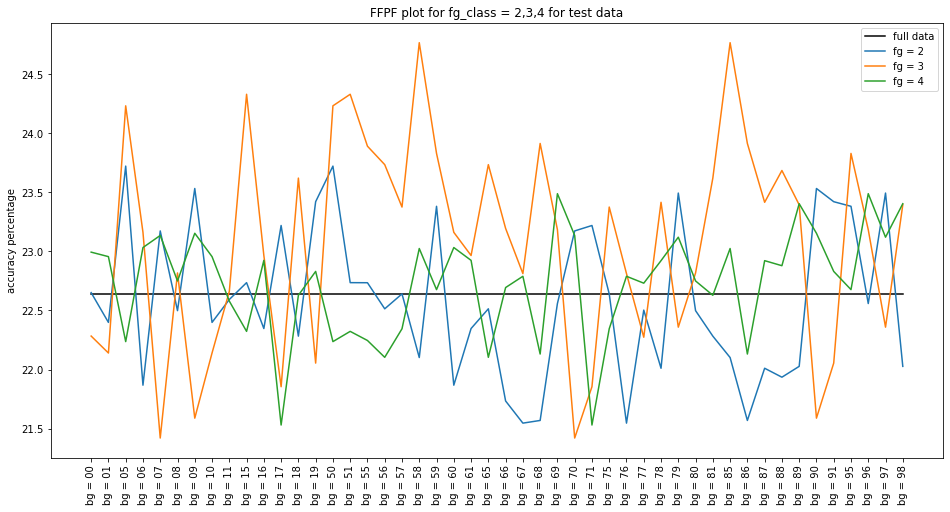

In [53]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 3 , Repetition allowed
## 333 in BG, 334 in BG, 335 in BG and so on
## On Training DATA


In [54]:
size3_table=[]
size3_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1, b2, b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in train_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 30000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s ):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1) + str(b2) +str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table.append(entry)
          entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size3_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000    66.8233    31.9333  0.16        1.08333             23540
      2  fg = 2          bg = 000                             7027    70.5707    27.9493  0.227693    1.25231              5681
      3  fg = 2          bg = 001                             4769    70.7276    27.7836  0.209688    1.27909              3879
      4  fg = 2          bg = 005                             4806    70.2247    28.2772  0.187266    1.31086              3893
      5  fg = 2          bg = 006                             4787    69.8559    28.5147  0.188009    1.4414               3834
      6  fg = 2          bg = 007                 

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size3_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table[i])

In [56]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size3_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  1.083333          23540
1      2          fg = 2  ...  1.252313           5681
2      3          fg = 2  ...  1.279094           3879
3      4          fg = 2  ...  1.310861           3893
4      5          fg = 2  ...  1.441404           3834

[5 rows x 9 columns]

In [57]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 344,686
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

66.82333333333334 31.93333333333333 0.16 1.0833333333333333
[70.57065604098476 70.72761585237996 70.2247191011236 69.85585961980364]
[55.99380194393578 56.025456785054395 54.878048780487795 54.80710349050827]
[74.56140350877193 74.84942886812046 73.67010309278349 74.01981015270327]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size3/train/"

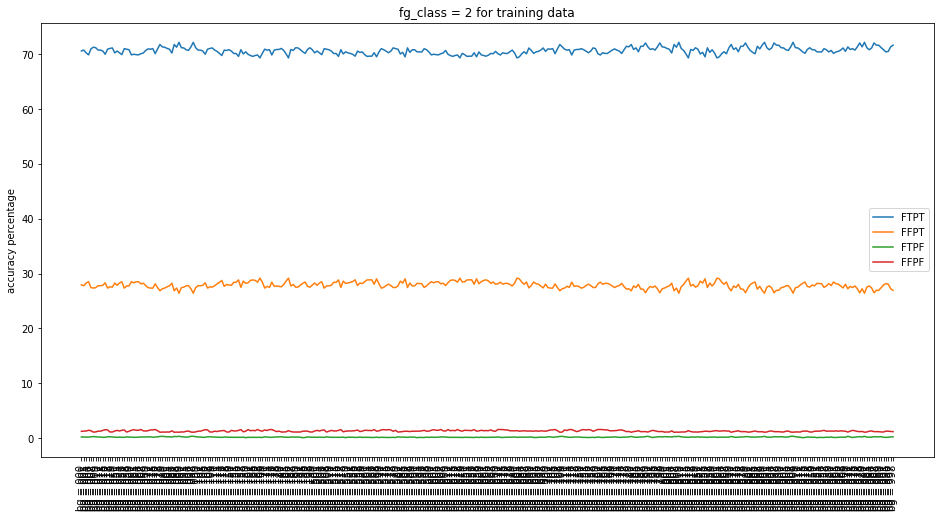

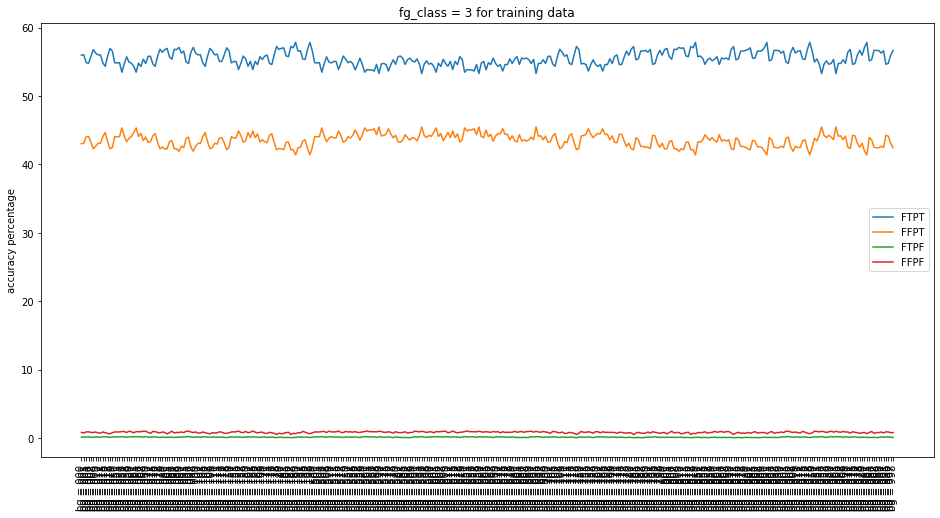

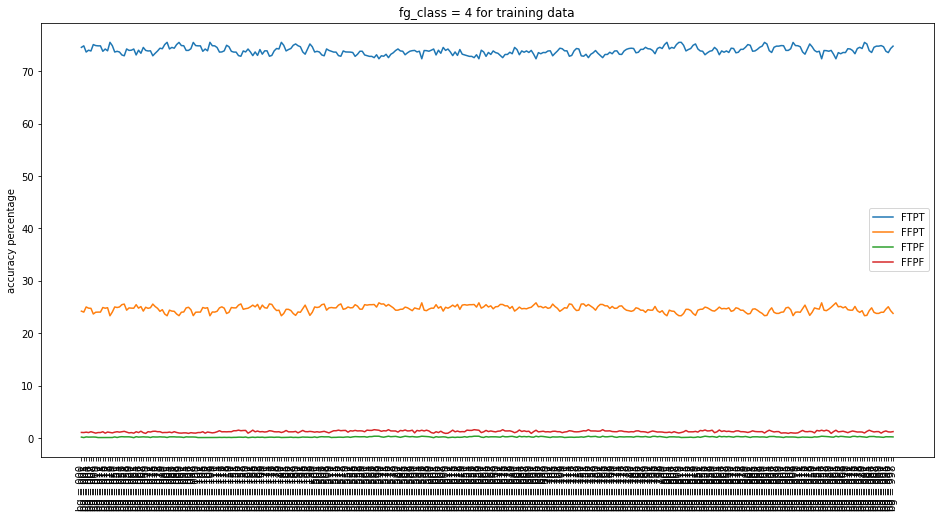

In [59]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

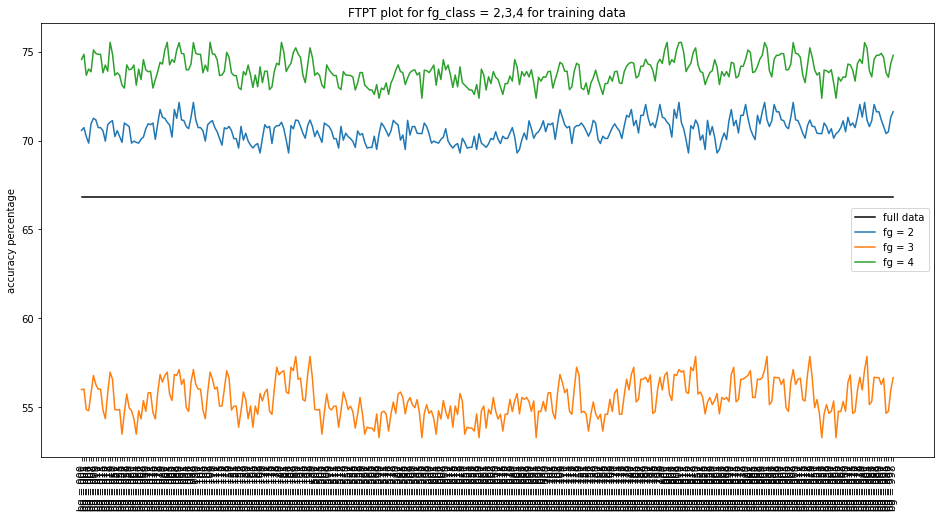

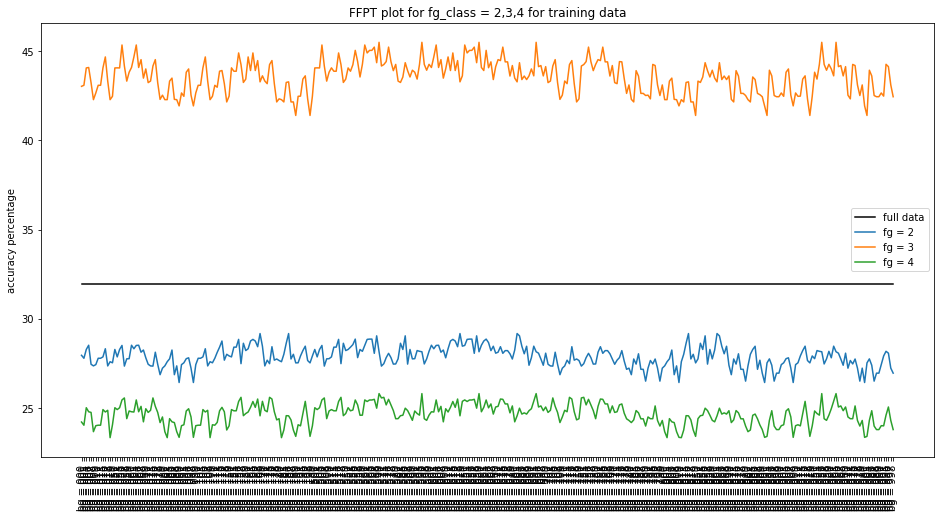

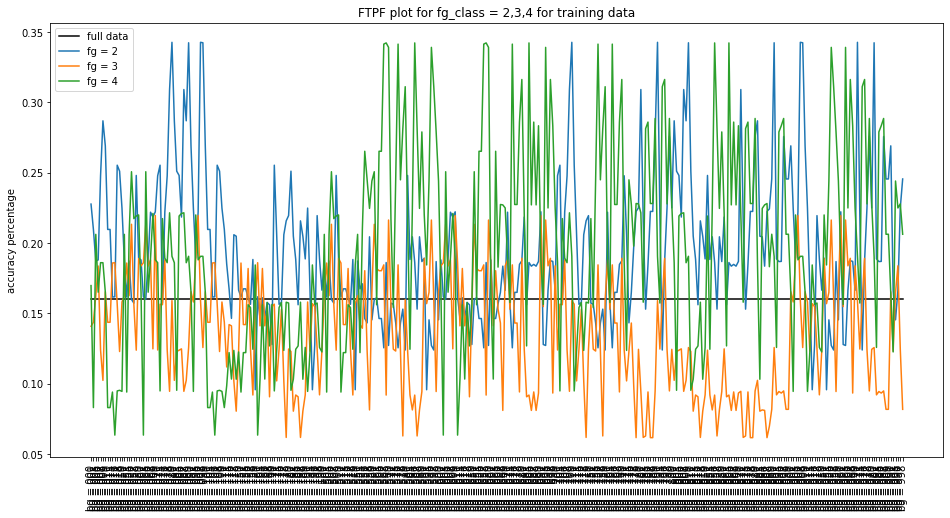

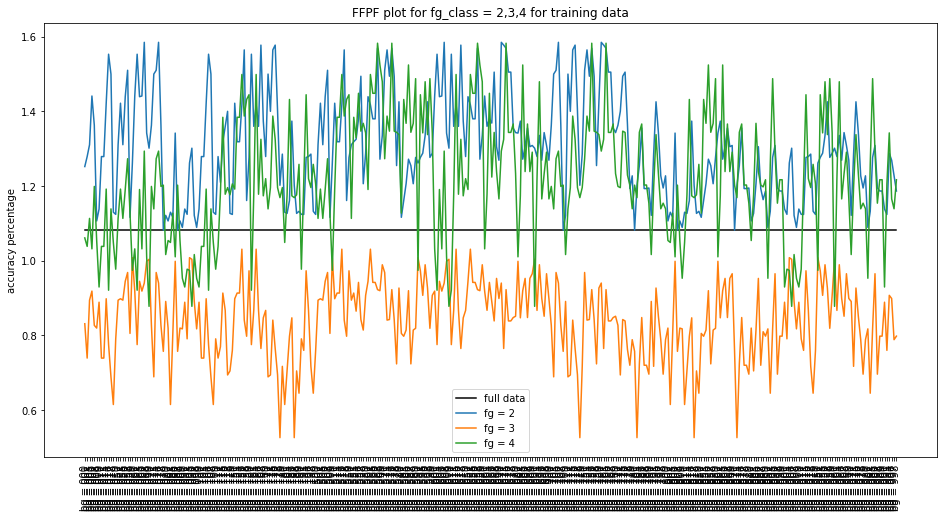

In [60]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [61]:
size3_table_test=[]
size3_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1,b2,b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in test_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 10000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+str(b2)+str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table_test.append(entry)
          entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size3_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000    56.37      13.99      7          22.64               7467
      2  fg = 2          bg = 000                             2384    56.7534    14.1779    6.41779    22.651              1781
      3  fg = 2          bg = 001                             1634    56.6707    14.1371    6.79315    22.399              1233
      4  fg = 2          bg = 005                             1644    55.4136    14.5985    6.26521    23.7226             1211
      5  fg = 2          bg = 006                             1628    57.3096    14.312     6.51106    21.8673             1225
      6  fg = 2          bg = 007                     

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_" + str(fg_used) + "/" + "size3_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table_test[i])

In [63]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_"+str(fg_used) + "/" + "size3_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  22.640000           7467
1      2          fg = 2  ...  22.651007           1781
2      3          fg = 2  ...  22.399021           1233
3      4          fg = 2  ...  23.722628           1211
4      5          fg = 2  ...  21.867322           1225

[5 rows x 9 columns]

In [64]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 344,686
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

56.37 13.99 7.0 22.64
[56.75335570469799 56.670746634026926 55.413625304136254 57.30958230958231]
[56.87103594080339 57.57575757575758 55.2760736196319 55.88235294117647]
[55.694564279551344 56.03773584905661 56.35324015247777 55.139593908629436]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase2/fg_' + str(fg_used) + "/size3/test/"

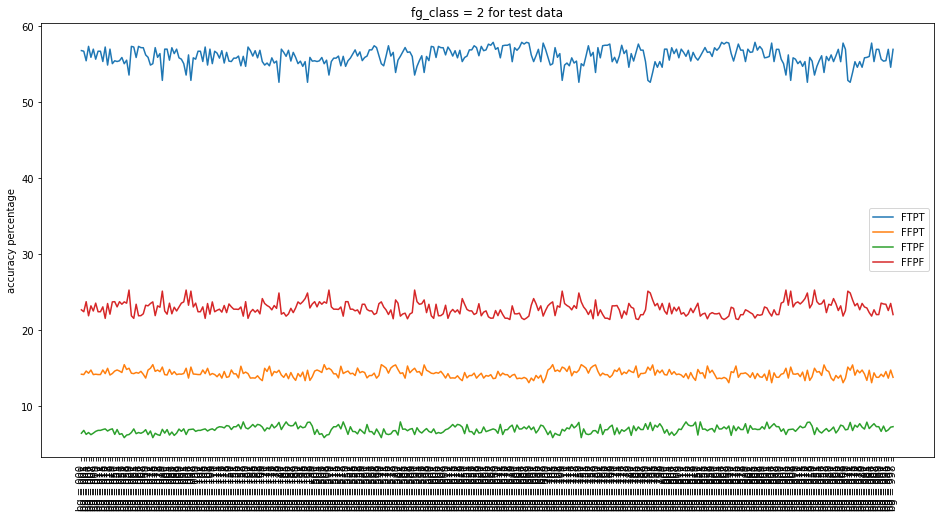

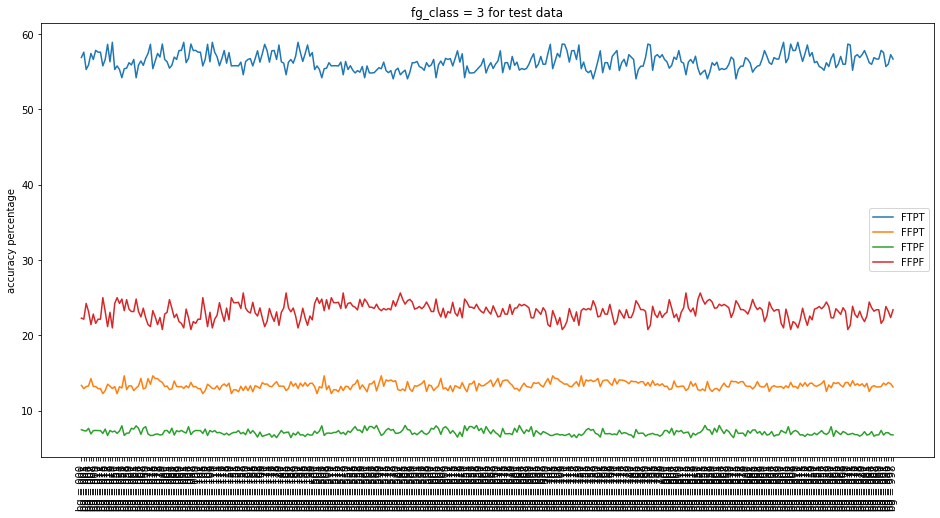

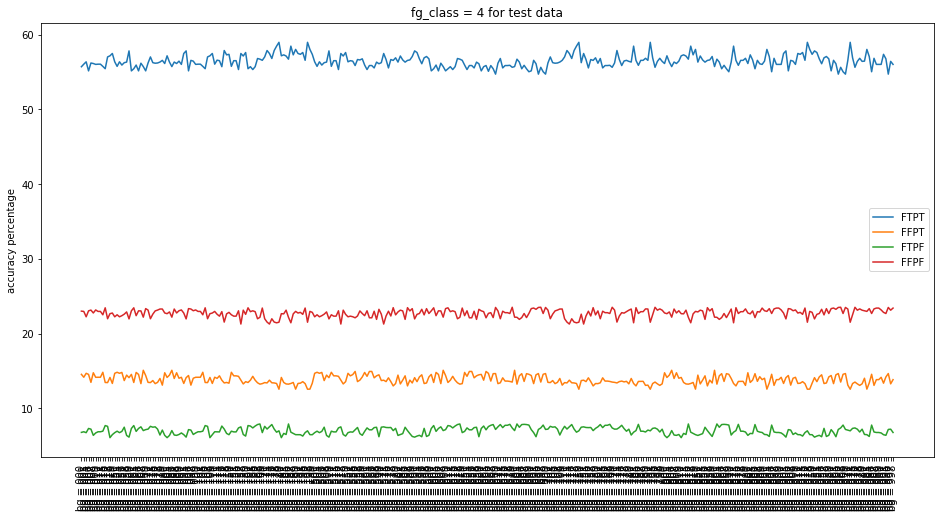

In [66]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

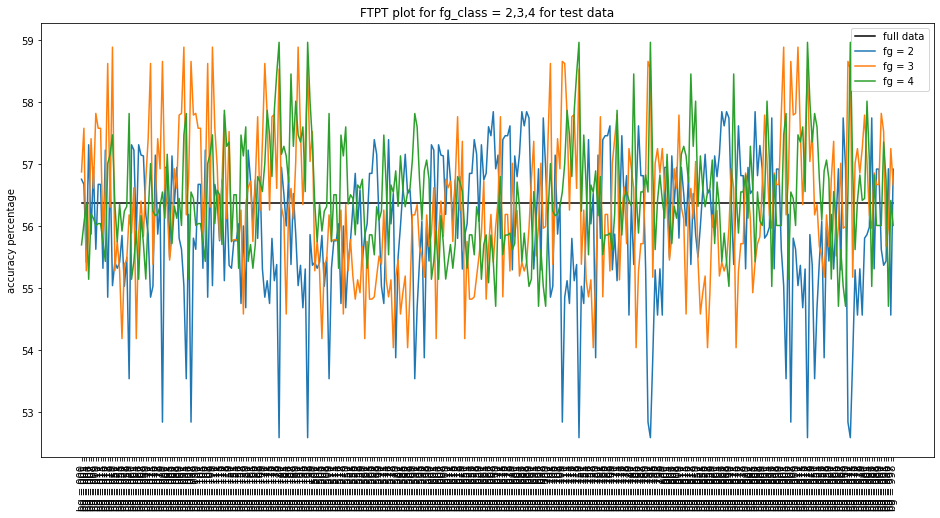

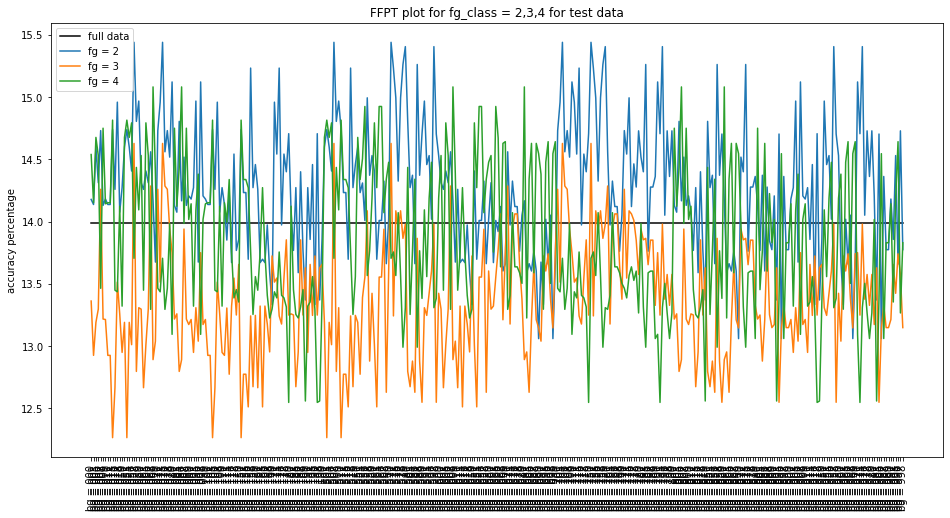

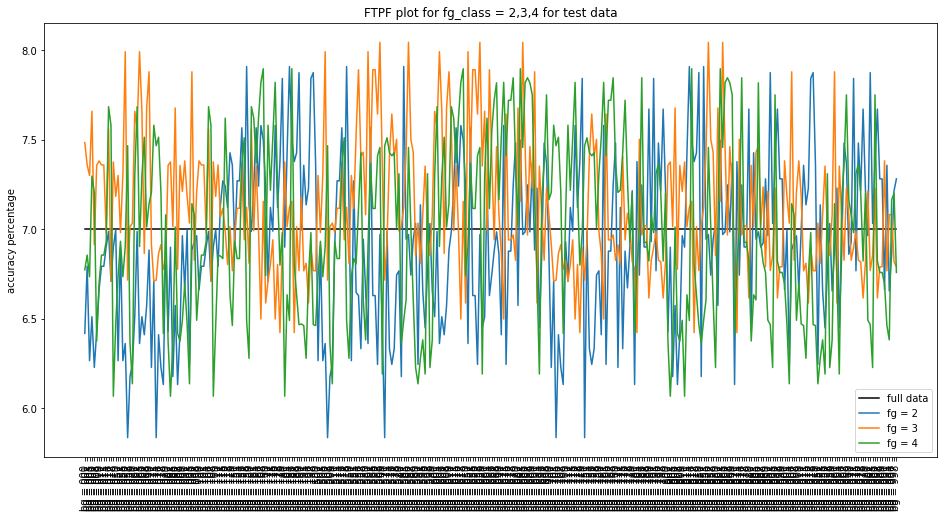

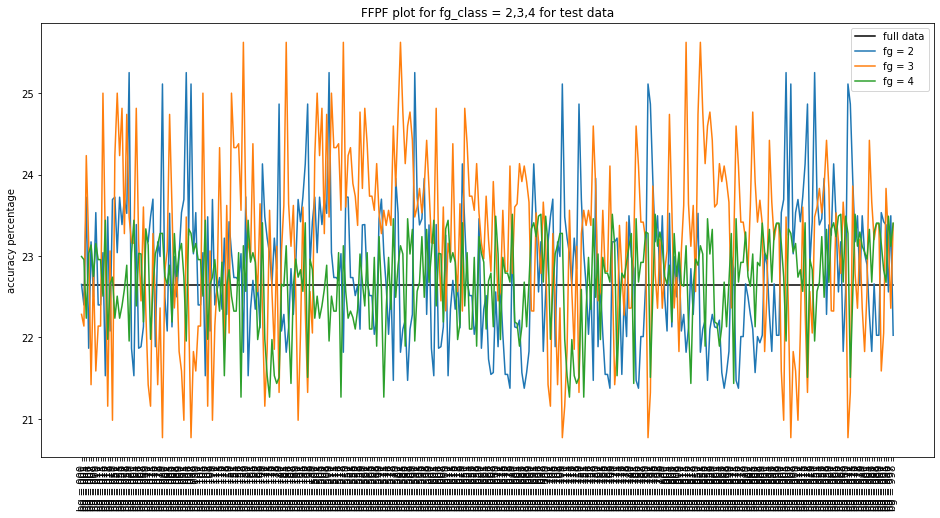

In [67]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')